In [2]:
import pickle as pkl
import xarray as xr
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import genextreme as gev
import lmoments3 as lm3
import lmoments3.distr as ldist 

In [ ]:
durations = [10, 30, 60, 360, 720, 1440]
durations_labels = ['10MIN', '30MIN', '1H', '6H', '12H', '24H']
return_periods = np.array([1, 2, 5, 10, 20, 50]) #years
data_orig = joblib.load(f'./ds_point_835x_520y_and_neighbors_5x5_present.pkl')
data = data_orig.resample(time='1H').sum()
pot_thres = data.groupby('time.year').max('time').min('year'
pot_max = data.groupby('time.year').max('time').max('year')
#data_extremes = data.where(data >= pot_thres, drop=True)

In [3]:
data_extremes = data.where(data >= pot_thres, drop=True)
center = data_extremes.sel(x=2, y=2).dropna('time')


### Fit distribution to GEV using Maximum Likelihood Estimation

In [4]:
shape, loc, scale = gev.fit(center.values)
l = loc + scale / shape
print('Fitting to GEV distribution using MLE')
print(f"Shape: {shape}, Location: {loc}, Scale: {scale}")

Fitting to GEV distribution using MLE
Shape: -0.6868051426364445, Location: 23.069584353613994, Scale: 3.2186173374749565


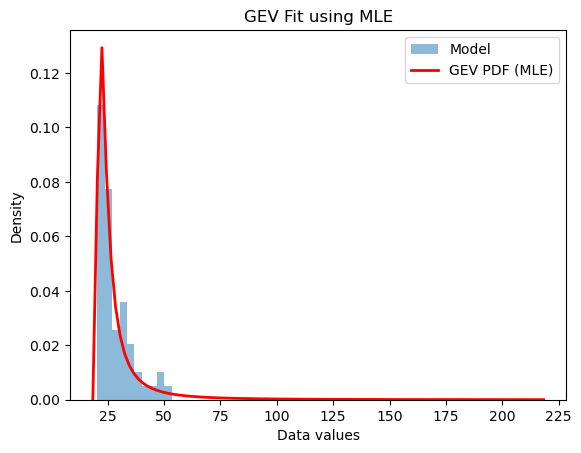

In [6]:
#Plotting
xx = np.linspace(l+0.00001, l+0.00001+200, num=100)
#xx = np.linspace(min(rain_over_threshold), max(rain_over_threshold), 100)
pdf_gev = gev.pdf(xx, shape, loc, scale)
plt.hist(center, bins=10, density=True, alpha=0.5, label="Model")
plt.plot(xx, pdf_gev, 'r-', lw=2, label="GEV PDF (MLE)")
plt.xlabel("Data values")
plt.ylabel("Density")
plt.title("GEV Fit using MLE")
plt.legend()
plt.show()



In [7]:
center.max().values

array(53.32097, dtype=float32)

### Fit distribution to GEV using L-Moments (adequate for small samples)

In [8]:
lmom = lm3.lmom_ratios(center, nmom=5)
print(f"Sample L-moments: {lmom}")
gev_params = ldist.gev.lmom_fit(center)
print(f"Fitted GEV parameters using L-moments:")
print(f"Shape: {gev_params['c']}, Location: {gev_params['loc']}, Scale: {gev_params['scale']}")
shape, loc, scale = gev_params['c'], gev_params['loc'], gev_params['scale']
l = loc + scale / shape

Sample L-moments: [27.712623693175235, 3.992367176477286, 0.3394929981386397, 0.1419852291124141, 0.08821375974734755]
Fitted GEV parameters using L-moments:
Shape: -0.2478769856630573, Location: 23.83496568895773, Scale: 4.3179404700771356


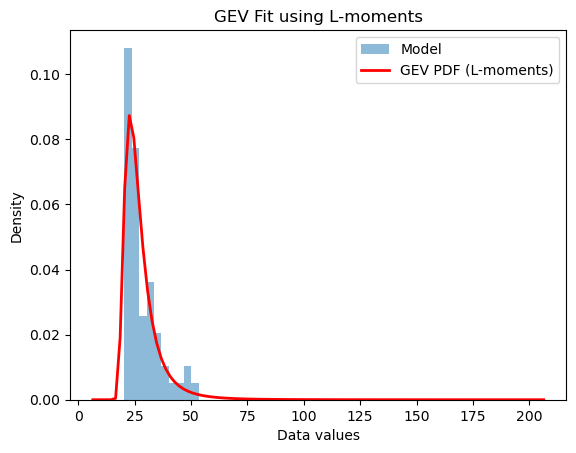

In [15]:
#Plotting
xx = np.linspace(l+0.00001, l+0.00001+200, num=100)
#xx = np.linspace(min(rain_over_threshold), max(rain_over_threshold), 100)
pdf_gev = ldist.gev.pdf(xx, **gev_params)
plt.hist(center, bins=10, density=True, alpha=0.5,  label="Model")
plt.plot(xx, pdf_gev, 'r-', lw=2, label="GEV PDF (L-moments)")
plt.xlabel("Data values")
plt.ylabel("Density")
plt.title("GEV Fit using L-moments")
plt.legend()
plt.show()

In [18]:
#data_extremes and center
n_bootstrap = 1000
total_years = 10
λ_u = center.count().values / total_years  
print(λ_u)
#return_levs_center =  (scale / shape) * ((λ_u * return_periods) ** shape - 1)
return_levs_center = stats.genextreme.ppf(1 - 1/(λ_u*return_periods), c=shape, loc=loc, scale=scale)
return_levs = np.zeros((n_bootstrap, len(return_periods)))

for i in range(n_bootstrap):
    bt_pot_thres = np.random.choice(pot_thres.values.flatten(), size=1, replace=False)
    bt_data_extremes = data.where(data >= bt_pot_thres, drop=True)
    n_exceedances = bt_data_extremes.count('time').values
    stacked = bt_data_extremes.stack(grid=("time", "y", "x"))
    valid_data = stacked.dropna(dim="grid", how="any")
    select_n_exceedances = np.random.choice(n_exceedances.flatten(), size=1, replace=False)
    λ_u = select_n_exceedances / total_years
    select_data = np.random.choice(valid_data, size=select_n_exceedances, replace=False)
    # print(select_n_exceedances)
    # print(valid_data.shape)    
    # print(select_data.shape)
    lmom = lm3.lmom_ratios(select_data, nmom=2)
    gev_params_bs = ldist.gev.lmom_fit(center)
    shape_bs, loc_bs, scale_bs = gev_params_bs['c'], gev_params_bs['loc'], gev_params_bs['scale']
    return_levs[i,:] = stats.genextreme.ppf(1 - 1/(λ_u*return_periods), c=shape_bs, loc=loc_bs, scale=scale_bs)
    #return_levs[i, :] = bt_pot_thres + (scale_bs / shape_bs) * ((λ_u * return_periods) ** shape_bs - 1)

return_level_ci_lower = np.percentile(return_levs, 1, axis=0)
return_level_ci_upper = np.percentile(return_levs, 99, axis=0)
errors_low = return_level_ci_lower
errors_up = return_level_ci_upper

5.9


In [19]:
print(errors_up)
print(errors_low)
print(return_levs_center)

[34.52124251 40.09687798 48.90704548 56.95850988 66.48396792 81.83889961]
[22.88858948 27.74439026 34.10572902 39.61809082 46.02538309 56.26057639]
[32.85611226 38.18431096 46.55039643 54.17645965 63.18993467 77.71202953]


In [28]:
### Fit distribution to GEV using L-Moments (adequate for small samples) all periods
durations = [10, 30, 60, 360, 720, 1440]
durations_labels = ['10MIN', '30MIN', '1H', '6H', '12H', '24H']
return_periods = np.array([1, 2, 5, 10, 20, 50]) #years
data_orig = joblib.load(f'./ds_point_835x_520y_and_neighbors_5x5_present.pkl')
n_bootstrap = 1000
total_years = 10
return_levs = np.zeros((n_bootstrap, len(return_periods), len(durations)))
errors_lo = np.zeros((len(return_periods), len(durations)))
errors_hi = np.zeros((len(return_periods), len(durations)))
return_levs_center = np.zeros((len(return_periods), len(durations)))

for idur in range(len(durations)):
    data = data_orig.resample(time=durations_labels[idur]).sum()
    pot_thres = data.groupby('time.year').max('time').min('year')
    pot_max = data.groupby('time.year').max('time').max('year')
    data_extremes = data.where(data >= pot_thres, drop=True)
    center = data_extremes.sel(x=2, y=2).dropna('time')
    lmom = lm3.lmom_ratios(center, nmom=3)
    gev_params = ldist.gev.lmom_fit(center)
    shape, loc, scale = gev_params['c'], gev_params['loc'], gev_params['scale']
    l = loc + scale / shape
    λ_u = center.count().values / total_years  
    return_levs_center[:,idur] = stats.genextreme.ppf(1 - 1/(λ_u*return_periods), c=shape, loc=loc, scale=scale)

    for i in range(n_bootstrap):
        bt_pot_thres = np.random.choice(pot_thres.values.flatten(), size=1, replace=False)
        bt_data_extremes = data.where(data >= bt_pot_thres, drop=True)
        n_exceedances = bt_data_extremes.count('time').values
        stacked = bt_data_extremes.stack(grid=("time", "y", "x"))
        valid_data = stacked.dropna(dim="grid", how="any")
        select_n_exceedances = np.random.choice(n_exceedances.flatten(), size=1, replace=False)
        λ_u = select_n_exceedances / total_years
        select_data = np.random.choice(valid_data, size=select_n_exceedances, replace=False)

        lmom = lm3.lmom_ratios(select_data, nmom=3)
        gev_params_bs = ldist.gev.lmom_fit(center)
        shape_bs, loc_bs, scale_bs = gev_params_bs['c'], gev_params_bs['loc'], gev_params_bs['scale']
        return_levs[i,:,idur] = stats.genextreme.ppf(1 - 1/(λ_u*return_periods), c=shape_bs, loc=loc_bs, scale=scale_bs)
    
errors_lo = np.percentile(return_levs, 1, axis=0)
errors_hi = np.percentile(return_levs, 99, axis=0)



In [35]:
print(errors_hi)
print(errors_lo)
print(return_levs_center)
return_periods = np.array([1, 2, 5, 10, 20, 50]) #years


[[         nan  23.88471148  34.52124251          nan          nan
           nan]
 [ 13.26218476  26.61774174  40.09687798 110.27847096          nan
           nan]
 [ 15.17171312  30.50233281  48.90704548 129.38612846 158.77711195
  199.10508136]
 [ 16.9183975   33.70094636  56.95850988 146.96510319 179.04993138
  228.15787241]
 [ 18.98312314  37.15887206  66.48396792 167.96543798 202.7348994
  263.14143563]
 [ 22.30548602  42.17603602  81.83889961 202.26951262 240.46405689
  320.75807148]]
[[         nan  17.65053754  22.25818307          nan          nan
           nan]
 [  9.75030069  20.4888331   27.25179435  80.37504631          nan
           nan]
 [ 10.9801455   23.97640985  33.55942714  95.50689433 117.9523711
  124.02964333]
 [ 12.01724664  26.71437537  38.99007329 107.33272321 132.62000049
  140.77188124]
 [ 13.21200606  29.62621232  45.29073883 120.89888711 148.89425771
  159.08877419]
 [ 15.10957663  33.81526379  55.34654564 142.63584029 174.20635576
  188.06376529]]
[[ 1

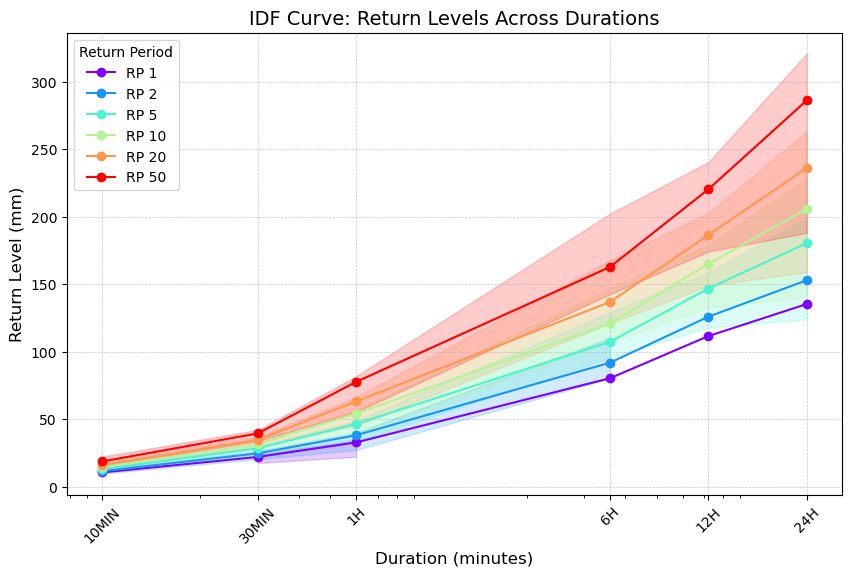

In [36]:

ds_idf_present = xr.Dataset(
    {
        "return_levels": (["duration", "return_period"], return_levs_center.T),
        "error_low": (["duration", "return_period"], errors_lo.T),
        "error_up": (["duration", "return_period"], errors_hi.T),
    },
    coords={
        "duration": durations, #np.arange(1, len(durations) + 1),  # Durations from 1 to 30
        "return_period": return_periods,  # Return periods
    },
    attrs={"duration_labels": durations_labels}
)

# Extract values from xarray dataset (ds_idf)
durations = ds_idf_present["duration"].values  # X-axis (duration)
# Extract duration labels if available
duration_labels = ds_idf_present.attrs.get("duration_labels", durations.astype(str))
return_periods = ds_idf_present["return_period"].values  # Legend categories (return periods)
#return_levels_p = ds_idf_present["return_levels"].values  # Main plot values (y-axis)
#error_low_p = ds_idf_present["error_low"].values  # Lower error bounds
#error_up_p = ds_idf_present["error_up"].values  # Upper error bounds

#return_levels_f = ds_idf_future["return_levels"].values  # Main plot values (y-axis)
#error_low_f = ds_idf_future["error_low"].values  # Lower error bounds
#error_up_f = ds_idf_future["error_up"].values  # Upper error bounds

# Define colors for each return period using rainbow colormap
colors = {rp: color for rp, color in zip(return_periods, plt.cm.rainbow(np.linspace(0, 1, len(return_periods))))}

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each return period as a separate curve
for i, rp in enumerate(return_periods):
    #ax.plot(durations, return_levels_p[:, i], label=f"RP {rp}", color=colors[rp], marker='o', linestyle='-')
    #ax.fill_between(durations, error_low_p[:, i], error_up_f[:, i], color=colors[rp], alpha=0.2)

    ax.plot(durations, ds_idf_present.return_levels.sel(return_period=rp), label=f"RP {rp}", color=colors[rp], marker='o', linestyle='-')
    ax.fill_between(durations, ds_idf_present.error_low.sel(return_period=rp), ds_idf_present.error_up.sel(return_period=rp), color=colors[rp], alpha=0.2)

    #ax.plot(durations, ds_idf_future.return_levels.sel(return_period=rp), label=f"RP {rp}", color=colors[rp], marker='o', linestyle=':')
    #ax.fill_between(durations, ds_idf_future.error_low.sel(return_period=rp), ds_idf_future.error_up.sel(return_period=rp), color=colors[rp], alpha=0.2)

# Formatting
ax.set_xscale("log")  # Log scale for durations
#ax.set_yscale("log")  # Log scale for return levels
ax.set_xlabel("Duration (minutes)", fontsize=12)
ax.set_ylabel("Return Level (mm)", fontsize=12)
ax.set_title("IDF Curve: Return Levels Across Durations", fontsize=14)
ax.legend(title="Return Period", fontsize=10)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Set xticks and labels
ax.set_xticks(durations)
ax.set_xticklabels(duration_labels, rotation=45)

# Show the plot
plt.show()


In [23]:
durations = [10, 30, 60, 360, 720, 1440]
durations_labels = ['10MIN', '30MIN', '1H', '6H', '12H', '24H']
return_periods = np.array([1, 2, 5, 10, 20, 50]) #years
data_orig = joblib.load(f'./ds_point_835x_520y_and_neighbors_5x5_present.pkl')
pot_thres = data.groupby('time.year').max('time').min('year')
pot_max = data.groupby('time.year').max('time').max('year')
#data_extremes = data.where(data >= pot_thres, drop=True)
data_extremes = data.where(data >= pot_thres, drop=True)
center = data_extremes.sel(x=2, y=2).dropna('time')
return_levels_data = np.zeros((len(durations), len(return_periods))) 

for idur in range(len(durations)):
    window = int(durations[idur] / durations[0])
    data = data_orig.coarsen(time=window).sum()
    pot_thres = data.groupby('time.year').max('time').min('year')
    data_extremes = data.where(data >= pot_thres, drop=True)
    center = data_extremes.sel(x=2, y=2).dropna('time')
    exceedances = center - pot_thres.sel(x=2,y=2)
    shape, loc, scale = stats.genpareto.fit(exceedances.values, floc=0)
    print(f"Duration {durations[idur]} min → Shape ξ: {shape:.4f}")

    n_exceedances = len(exceedances)
    total_years = 10
    λ_u = n_exceedances / total_years 

    return_levels_data[idur, :] = pot_thres.sel(x=2,y=2).item() + (scale / shape) * ((λ_u * return_periods) ** shape - 1)



Duration 10 min → Shape ξ: 0.0217
Duration 30 min → Shape ξ: -0.0964
Duration 60 min → Shape ξ: 0.0682
Duration 360 min → Shape ξ: -0.0108
Duration 720 min → Shape ξ: -0.2029
Duration 1440 min → Shape ξ: 0.0304
